In [1]:
import numpy as np
import torch
import h5py
import os

from dataset import Spectrogram, SpectrogramParamDataset
from embedding import Encoder, EncoderWrapper, VICRegLoss

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

from flows import make_flow

## Data

In [2]:
num_files = 1

data_dir = '/Users/shreyaggarwal/Desktop/Project8581/data/train/'

## Data Loader

In [3]:

torch_dataset = SpectrogramParamDataset(data_dir, 1, weights='emb.pth', progress=True)

train_set_size = 0.8
val_set_size = 0.1
test_set_size = 0.1

train_data, val_data, test_data = torch.utils.data.random_split(
    torch_dataset, [train_set_size, val_set_size, test_set_size])

del torch_dataset

TRAIN_BATCH_SIZE = 30
VAL_BATCH_SIZE = 30

train_data_loader = DataLoader(
    train_data, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True
)

val_data_loader = DataLoader(
    val_data, batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_data_loader = DataLoader(
    test_data, batch_size=1,
    shuffle=False
)

  0%|                                                     | 0/1 [00:05<?, ?it/s]
/Users/shreyaggarwal/Desktop/Project8581/repo-PE/dataset.py:168: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

em
em


In [5]:
del torch_dataset

NameError: name 'torch_dataset' is not defined

## Model

## Training

In [6]:
from flows import make_flow

flow = make_flow()
print("Total number of trainable parameters: ", sum(p.numel() for p in flow.parameters() if p.requires_grad))


Total number of trainable parameters:  232860


In [7]:
for idx, val in enumerate(train_data_loader, 1):
    if idx == 1:
        theta, data = val
        print(theta.shape, data.shape)

torch.Size([30, 10, 6]) torch.Size([30, 256])


In [8]:
num_augmentations = 10

train_loss = []
val_loss = []
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(train_data_loader, 1):
        theta, data = val
        theta = theta[:, 0]
        #print(augmented_theta.shape, augmented_data.shape)
        #augmented_theta = augmented_theta[:,0:2]
        #print(augmented_theta.shape, augmented_data.shape)

        loss = 0

        flow_loss = -flow.log_prob(theta, context=data).mean()
        optimizer.zero_grad()
        optimizer.step()

        loss += flow_loss.item()

        running_loss += loss/num_augmentations
        train_loss.append(running_loss)
        if idx % 10 == 0:
            last_loss = running_loss / 10 # avg loss
            #print(' Avg. train loss/batch after {} batches = {:.4f}'.format(idx, last_loss))
            tb_x = epoch_index * len(train_data_loader) + idx
            tb_writer.add_scalar('Flow Loss/train', last_loss, tb_x)
            tb_writer.flush()
            running_loss = 0.
    return last_loss


def val_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for idx, val in enumerate(val_data_loader, 1):
        theta, data = val
        theta = theta[:, 0]
        #augmented_theta = augmented_theta[:,0:2]

        loss = 0

        flow_loss = -flow.log_prob(theta, context=data).mean()
        loss += flow_loss.item()

        running_loss += loss/num_augmentations
        val_loss.append(running_loss)
        if idx % 5 == 0:
            last_loss = running_loss / 5
            tb_x = epoch_index * len(val_data_loader) + idx + 1
            tb_writer.add_scalar('Flow Loss/val', last_loss, tb_x)

            tb_writer.flush()
            running_loss = 0.
    tb_writer.flush()
    return last_loss

In [9]:
optimizer = optim.Adam(flow.parameters(), lr=1e-3)

scheduler_1 = optim.lr_scheduler.ConstantLR(optimizer, total_iters=5)
scheduler_2 = optim.lr_scheduler.OneCycleLR(optimizer, total_steps=20, max_lr=1e-3)
scheduler_3 = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

scheduler = optim.lr_scheduler.SequentialLR(
    optimizer, schedulers=[scheduler_1, scheduler_2, scheduler_3], milestones=[5, 20])

In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("gw-norm.pth", comment="With LR=1e-3", flush_secs=5)
epoch_number = 0

In [11]:
EPOCHS = 100

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    # Gradient tracking
    flow.train(True)
    avg_train_loss = train_one_epoch(epoch_number, writer)

    # no gradient tracking, for validation
    flow.train(False)
    avg_val_loss = val_one_epoch(epoch_number, writer)

    #print(f"Train/Val flow Loss after epoch: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
    #for param_group in optimizer.param_groups:
    #    #print("Current LR = {:.3e}".format(param_group['lr']))
    epoch_number += 1
    try:
        scheduler.step(avg_val_loss)
    except TypeError:
        scheduler.step()

EPOCH 1:
EPOCH 2:
EPOCH 3:
EPOCH 4:
EPOCH 5:
EPOCH 6:
EPOCH 7:
EPOCH 8:
EPOCH 9:
EPOCH 10:
EPOCH 11:
EPOCH 12:
EPOCH 13:
EPOCH 14:
EPOCH 15:
EPOCH 16:
EPOCH 17:
EPOCH 18:
EPOCH 19:
EPOCH 20:
EPOCH 21:
EPOCH 22:
EPOCH 23:
EPOCH 24:


/opt/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:232: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


EPOCH 25:
EPOCH 26:
EPOCH 27:
EPOCH 28:
EPOCH 29:
EPOCH 30:
EPOCH 31:
EPOCH 32:
EPOCH 33:
EPOCH 34:
EPOCH 35:
EPOCH 36:
EPOCH 37:
EPOCH 38:
EPOCH 39:
EPOCH 40:
EPOCH 41:
EPOCH 42:
EPOCH 43:
EPOCH 44:
EPOCH 45:
EPOCH 46:
EPOCH 47:
EPOCH 48:
EPOCH 49:
EPOCH 50:
EPOCH 51:
EPOCH 52:
EPOCH 53:
EPOCH 54:
EPOCH 55:
EPOCH 56:
EPOCH 57:
EPOCH 58:
EPOCH 59:
EPOCH 60:
EPOCH 61:
EPOCH 62:
EPOCH 63:
EPOCH 64:
EPOCH 65:
EPOCH 66:
EPOCH 67:
EPOCH 68:
EPOCH 69:
EPOCH 70:
EPOCH 71:
EPOCH 72:
EPOCH 73:
EPOCH 74:
EPOCH 75:
EPOCH 76:
EPOCH 77:
EPOCH 78:
EPOCH 79:
EPOCH 80:
EPOCH 81:
EPOCH 82:
EPOCH 83:
EPOCH 84:
EPOCH 85:
EPOCH 86:
EPOCH 87:
EPOCH 88:
EPOCH 89:
EPOCH 90:
EPOCH 91:
EPOCH 92:
EPOCH 93:
EPOCH 94:
EPOCH 95:
EPOCH 96:
EPOCH 97:
EPOCH 98:
EPOCH 99:
EPOCH 100:


In [12]:
PATH = './gw-norm1.pth'
torch.save(flow.state_dict(), PATH)

In [13]:
PATH = './gw-norm1.pth'
device='cpu'
flow.load_state_dict(torch.load(PATH, map_location=device))
flow.eval()

/var/folders/2c/g9pwmbpx46vcs7mmd9lxf1680000gn/T/ipykernel_83388/52377865.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  flow.load_state_dict(torch.load(PATH, map_locat

Flow(
  (_transform): CompositeTransform(
    (_transforms): ModuleList(
      (0): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=6, out_features=30, bias=True)
          (context_layer): Linear(in_features=256, out_features=30, bias=True)
          (blocks): ModuleList(
            (0-3): 4 x MaskedResidualBlock(
              (context_layer): Linear(in_features=256, out_features=30, bias=True)
              (linear_layers): ModuleList(
                (0-1): 2 x MaskedLinear(in_features=30, out_features=30, bias=True)
              )
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (final_layer): MaskedLinear(in_features=30, out_features=12, bias=True)
        )
      )
      (1): RandomPermutation()
      (2): MaskedAffineAutoregressiveTransform(
        (autoregressive_net): MADE(
          (initial_layer): MaskedLinear(in_features=6, out_features=30, bias=True)


In [20]:
def live_plot_samples(samples, truth):
    print(truth)
    clear_output(wait=True)
    sleep(0.5)
    print(samples.shape)
    figure = corner.corner(
        samples.numpy(),
        show_titles=True,
        #labels=list(gwpriors.keys()),
        truth=truth,
    )

    corner.overplot_lines(figure, truth, color="C1")
    corner.overplot_points(figure, truth[None], marker="s", color="C1")

In [28]:
ranges = [[min(s), max(s)] for s in samples.T]
ranges

/var/folders/2c/g9pwmbpx46vcs7mmd9lxf1680000gn/T/ipykernel_83388/4267120355.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3701.)
  ranges = [[min(s), max(s)] for s in samples.T]


[[tensor([-5844565.5000]), tensor([101843.9141])],
 [tensor([-8345445.]), tensor([3673.7888])],
 [tensor([-121665.3906]), tensor([38.3895])],
 [tensor([-795.2138]), tensor([5260134.])],
 [tensor([-40288.0156]), tensor([1.0657e+09])],
 [tensor([-8224.8779]), tensor([1.0028e+11])]]

torch.Size([3000, 6])


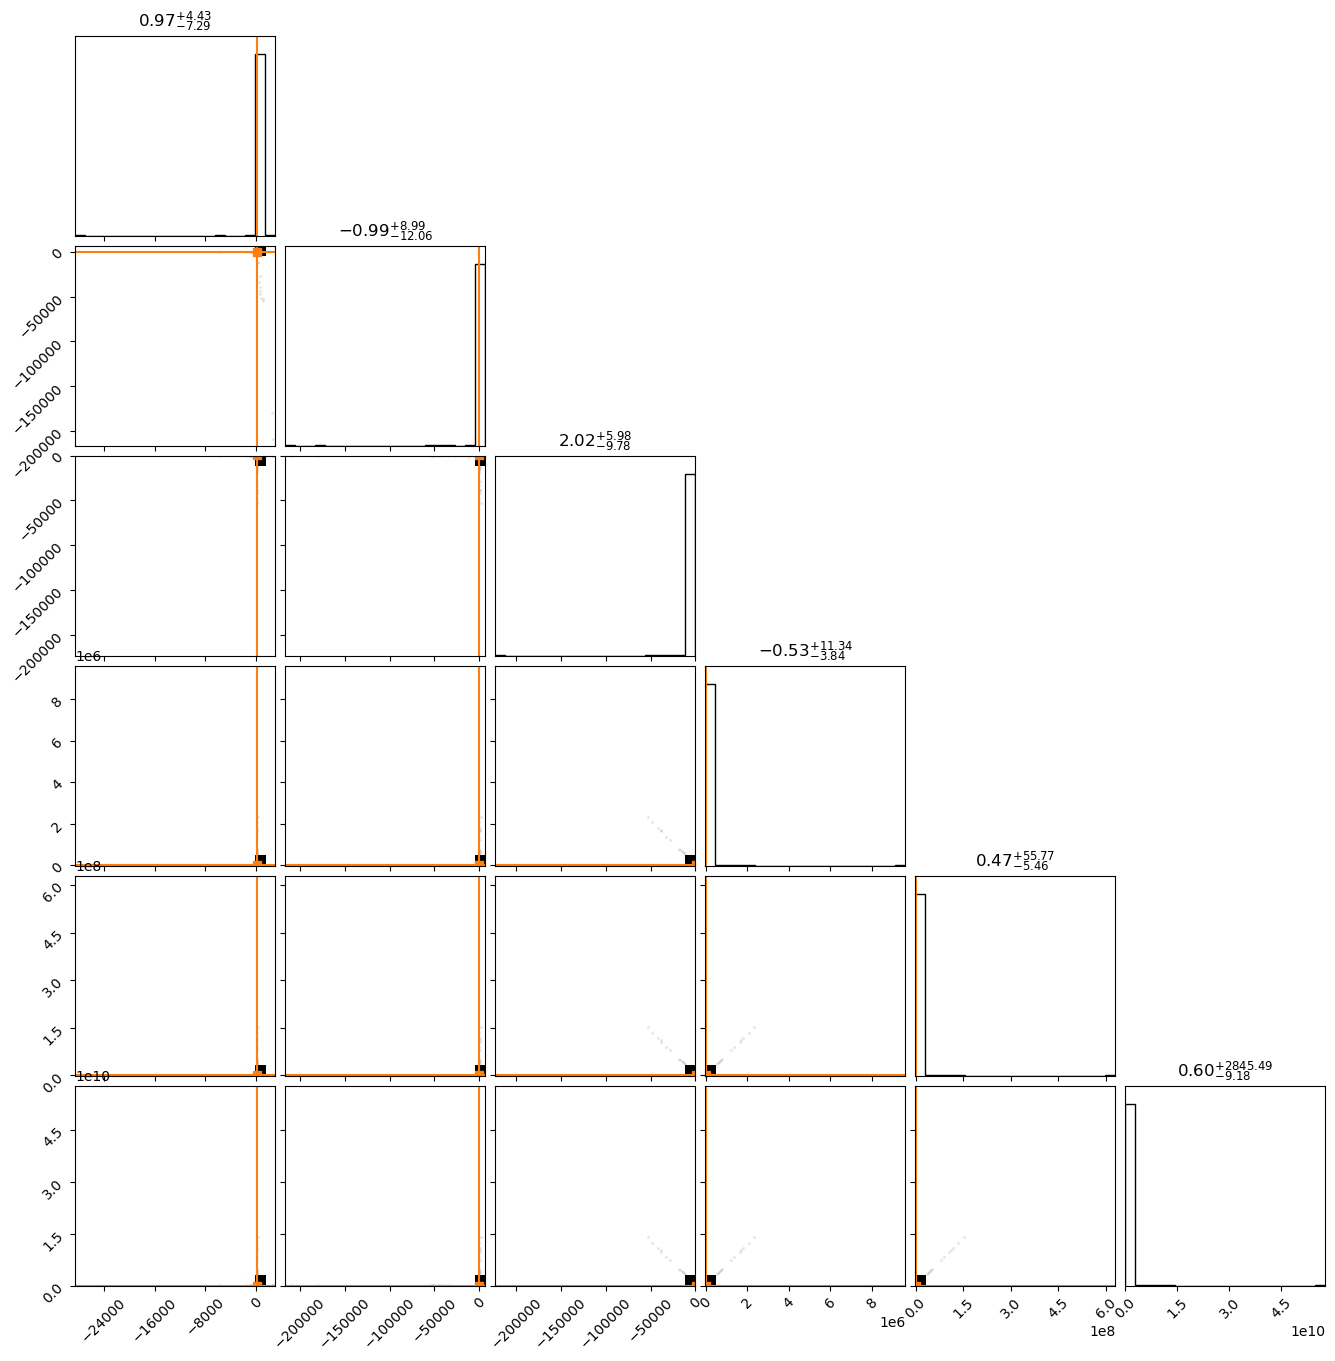

In [30]:
from IPython.display import clear_output
from time import sleep
import corner
import matplotlib.pyplot as plt

n_samples=256//2

for idx, (theta_test, data_test) in enumerate(test_data_loader):
    if idx % 450 !=0: continue 
    with torch.no_grad():
        samples = flow.sample(3000, context=data_test)
    live_plot_samples(samples[0].cpu(), theta_test[0, 0].cpu())
    plt.show()

In [31]:
samples = flow.sample(3000, context=data_test)

In [32]:
samples.shape

torch.Size([1, 3000, 6])

In [33]:
theta_test.shape

torch.Size([1, 10, 6])

In [34]:
theta_test

tensor([[[ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01],
         [ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01],
         [ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01],
         [ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01],
         [ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01],
         [ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01],
         [ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01],
         [ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01],
         [ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01],
         [ 2.9253e+01,  3.6633e-01,  4.8895e+02,  1.7810e+00, -3.0159e+00,
          -1.9072e-01]]])

In [35]:
samples[0].numpy().shape

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [36]:
samples[0][:, 2]

tensor([-3.5462,  0.7466,  9.9453,  ...,  1.5281, -7.8317, -1.1240],
       grad_fn=<SelectBackward0>)

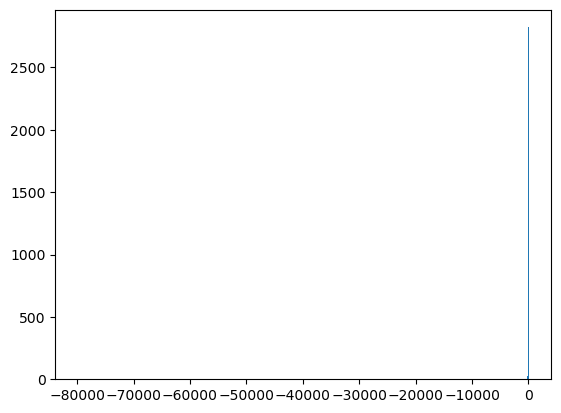

In [40]:
plt.hist(samples[0][:, 2].detach().numpy(), bins=1000)
plt.show()

In [50]:
samp = samples[0][:, 2].detach().numpy()

In [46]:
samp/np.mean(samp)

array([ 0.01427294, -0.003005  , -0.04002904, ..., -0.00615061,
        0.03152194,  0.00452392], dtype=float32)

In [51]:
np.argmin(samp)

607

In [48]:
samp = samp[samp > 0]

In [52]:
samp = list(samp)
samp.pop(607)

-79892.234

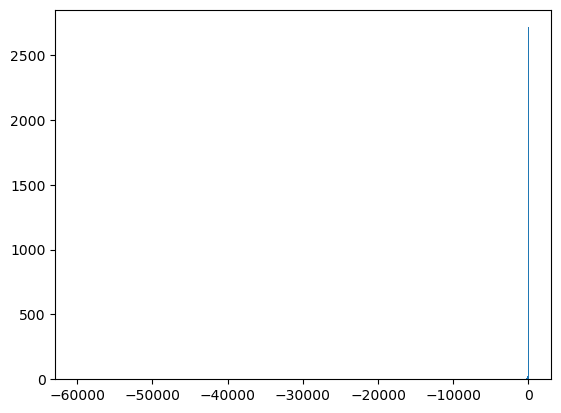

In [53]:
plt.hist(samp, bins=1000)
plt.show()